In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from utils import *
import matplotlib
plt.rcParams.update({'figure.figsize': (4,2.5), 'figure.dpi': 150, 'image.cmap': 'rocket',})

# Process results

In [3]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_8/')

In [4]:
data_df = pd.read_csv(data_path / 'summary.csv').drop(['Unnamed: 0'],axis=1)

In [5]:
data_df['path'] = data_df.apply(lambda x: pathlib.Path(x.path), axis=1)

In [6]:
errors = compute_errors(data_path)

  0%|          | 0/480 [00:00<?, ?it/s]

In [7]:
for k, df in errors.items():
    errors[k] = pd.merge(
        df, 
        data_df.loc[:, ['path', 'W_condition', 'W_smin', 'W_smax', 'x_condition',
           'x_smin', 'x_smax', 'cov_condition', 'cov_smin', 'cov_smax']],
        on='path'
    )

In [8]:
for k, df in errors.items():
    errors[k]['sigma'] = df.apply(lambda x: x['glorot_normal']['sigma'], axis=1)

/tmp/ipykernel_1494778/2551945340.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(mnorm.inverse(cbar.ax.get_yticks()).round())


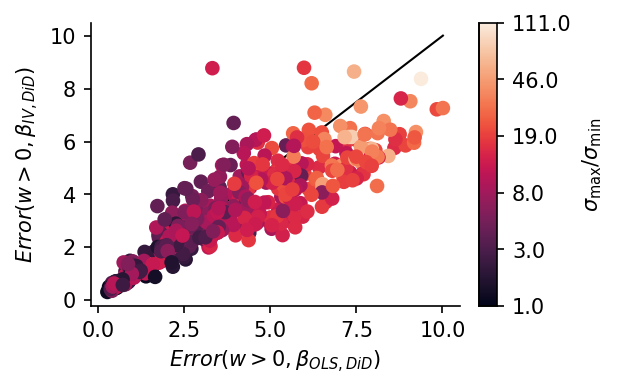

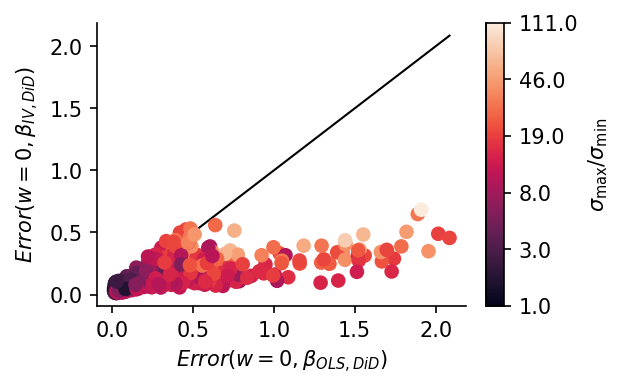

In [25]:
for k in errors:
    var1 = 'error_beta_ols_did'
    var2 = 'error_beta_iv_did'
    fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1}, figsize=(3.5,2.5), dpi=150)
    mnorm = matplotlib.colors.LogNorm()
    xmin, xmax = min(errors[k][var1].min(), errors[k][var2].min()), max(errors[k][var1].max(), errors[k][var2].max())
    sc = ax.scatter(errors[k][var1], errors[k][var2], c=mnorm(errors[k].cov_condition))
    ax.plot([xmin, xmax], [xmin, xmax], c='k', zorder=0, lw=1)
    lab1 = ",".join([labels[v] for v in var1.split("_")[2:]])
    lab2 = ",".join([labels[v] for v in var2.split("_")[2:]])
    elab = fr'$Error(w > 0, $' if k=='positives' else fr'$Error(w = 0, $'
    ax.set_xlabel(elab + fr'$\beta_{{{lab1}}})$')
    ax.set_ylabel(elab + fr'$\beta_{{{lab2}}})$')
    cbar = plt.colorbar(sc, cax=cax)
    cbar.ax.set_yticklabels(mnorm.inverse(cbar.ax.get_yticks()).round())
#     cbar.ax.set_ylabel(r'$||\mathrm{X}|| \times ||\mathrm{X}^{-1}||$')
    cbar.ax.set_ylabel(r'$\sigma_{\mathrm{max}} / \sigma_{\mathrm{min}}$')
    sns.despine()
    savefig(f'error_condition_{k}')

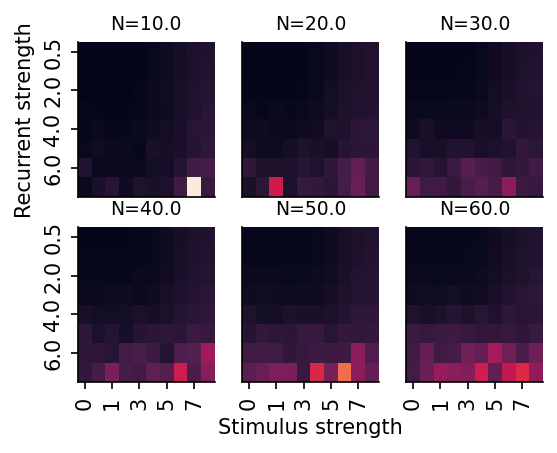

In [119]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=True, figsize=(4,3))
axs = axs.ravel()
for i, (n_neurons, df) in enumerate(errors[k].groupby('n_neurons')):
    ax = axs[i]
    sns.heatmap(
        df.pivot('sigma', 'stim_strength', 'cov_condition'), ax=ax,
        cbar=False, vmin=1, vmax=111
    )
    if i == 0:
        ax.set_ylabel('Recurrent strength')
    else:
        ax.set_ylabel('')
    if i == 4:
        ax.set_xlabel('Stimulus strength')
    else:
        ax.set_xlabel('')
    ax.set_xticklabels([0,1,3,5,7])
    ax.set_title(f'N={n_neurons}', fontsize=9)
    if i in [0,1,2]:
        ax.tick_params(
            axis='x',
            which='both',
            bottom=False)
    if i in [1,2,4,5]:
        ax.tick_params(
            axis='y',     
            which='both',
            left=False)
    
sns.despine()
savefig(f'condition_numbers')

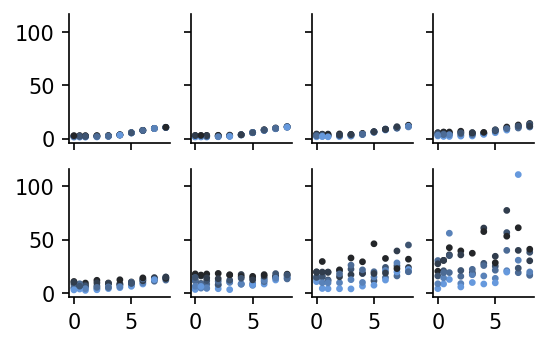

In [78]:
cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True)
fig, axs = plt.subplots(2,4, sharex=True, sharey=True, figsize=(4,2.5))
axs = axs.ravel()
for i, (sigma, df) in enumerate(errors[k].groupby('sigma')):
    axs[i].scatter(df.stim_strength, df.cov_condition, c=df.n_neurons, s=5, cmap=cmap)
sns.despine()

In [98]:
def violin_compare(var1, var2, x='stim_strength', k='positives'):
    plt.figure()
    v1 = errors[k].loc[:, [x, var1]].rename(columns={var1: 'Error'})
    key = lambda x: ','.join([labels[l] for l in x.split('_')[2:]])
    v1[''] = key(var1)
    v2 = errors[k].loc[:, [x, var2]].rename(columns={var2: 'Error'})
    v2[''] = key(var2)
    viodf = pd.concat([v1,v2])
    sns.violinplot(
        data=viodf, x=x, y='Error', hue='', split=True, inner="quart", linewidth=1,
                   palette={key(var1): colors[key(var1).lower()], key(var2): colors[key(var2).lower()]}, cut=0,
    )
    sns.despine()
    plt.legend(
        frameon=False,
        bbox_to_anchor=(0,1.0,1,0.2), 
        loc="lower left",
#         mode="expand", 
        borderaxespad=0, ncol=2)
    plt.ylabel('$Error(w > 0)$' if k=='positives' else '$Error(w = 0)$')
    plt.xlabel('Stimulus strength')
    plt.gca().set_xticklabels([0.0,0.5,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0]);
    savefig(f'comparison_stim_strength_{k}')

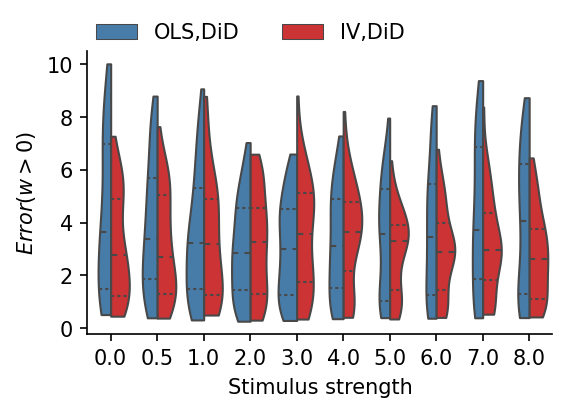

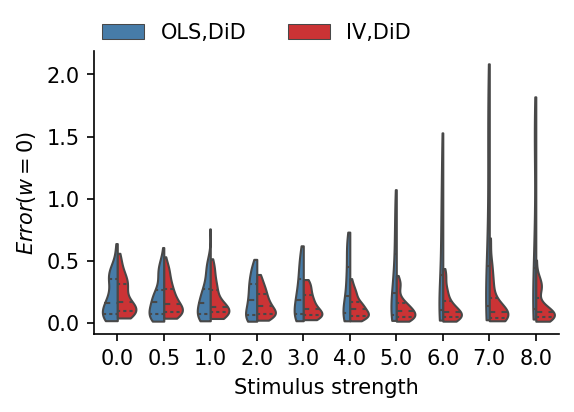

In [99]:
for k in errors:
    violin_compare('error_beta_ols_did', 'error_beta_iv_did', k=k)
#     violin_compare('error_beta_iv_did', 'error_beta_brew_did', k=k)

In [21]:
def violin_compare_all(var1,var2, k):
    
    plt.figure(figsize=(1.5,2.5))
    key = lambda x: ','.join([labels[l] for l in x.split('_')[2:]])
    viodf = pd.DataFrame()
    for var in [var1, var2]:
        v = pd.DataFrame()
        v['Error'] = errors[k].loc[:, var]
        v[''] = key(var)
        viodf = pd.concat([viodf,v])
    sns.violinplot(
        data=viodf, x='', y='Error', inner="quart", linewidth=1, cut=0,
        palette={key(var1): colors[key(var1).lower()], key(var2): colors[key(var2).lower()]}
    )
    plt.ylabel('$Error(w > 0)$' if k=='positives' else '$Error(w = 0)$')
    
    sns.despine()
    statistic, pvalue = scipy.stats.mannwhitneyu(
                errors[k].loc[:, var1],
                errors[k].loc[:, var2]
            )
    # significance
    if pvalue < 0.0001:
        significance = "****"
    elif pvalue < 0.001:
        significance = "***"
    elif pvalue < 0.01:
        significance = "**"
    elif pvalue < 0.05:
        significance = "*"
    else:
        significance = "ns"
    d = 0
    x1, x2 = [0,1]
    data_max = np.max(errors[k].loc[:, [var1, var2]].values.max())
    data_min = np.min(errors[k].loc[:, [var1, var2]].values.min())
    y = (data_max * 1.05)
    h = 0.025 * (data_max - data_min)
    d_ =  d * 0.15 * (data_max - data_min)
    plt.plot([x1, x1, x2, x2], np.array([y - h, y, y, y - h]) + d_, c='k')
    plt.text((x1 + x2) / 2, y + h + d_, significance, ha='center', va='bottom')
    savefig(f'comparison_summary_{k}')

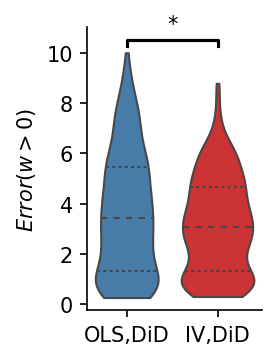

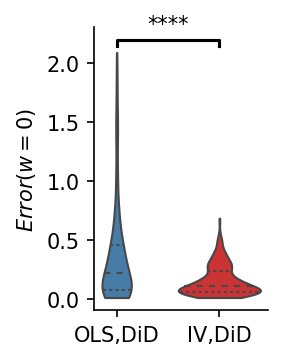

In [22]:
for k in errors:
    violin_compare_all('error_beta_ols_did', 'error_beta_iv_did', k=k)

# Compare error between OLS and IV

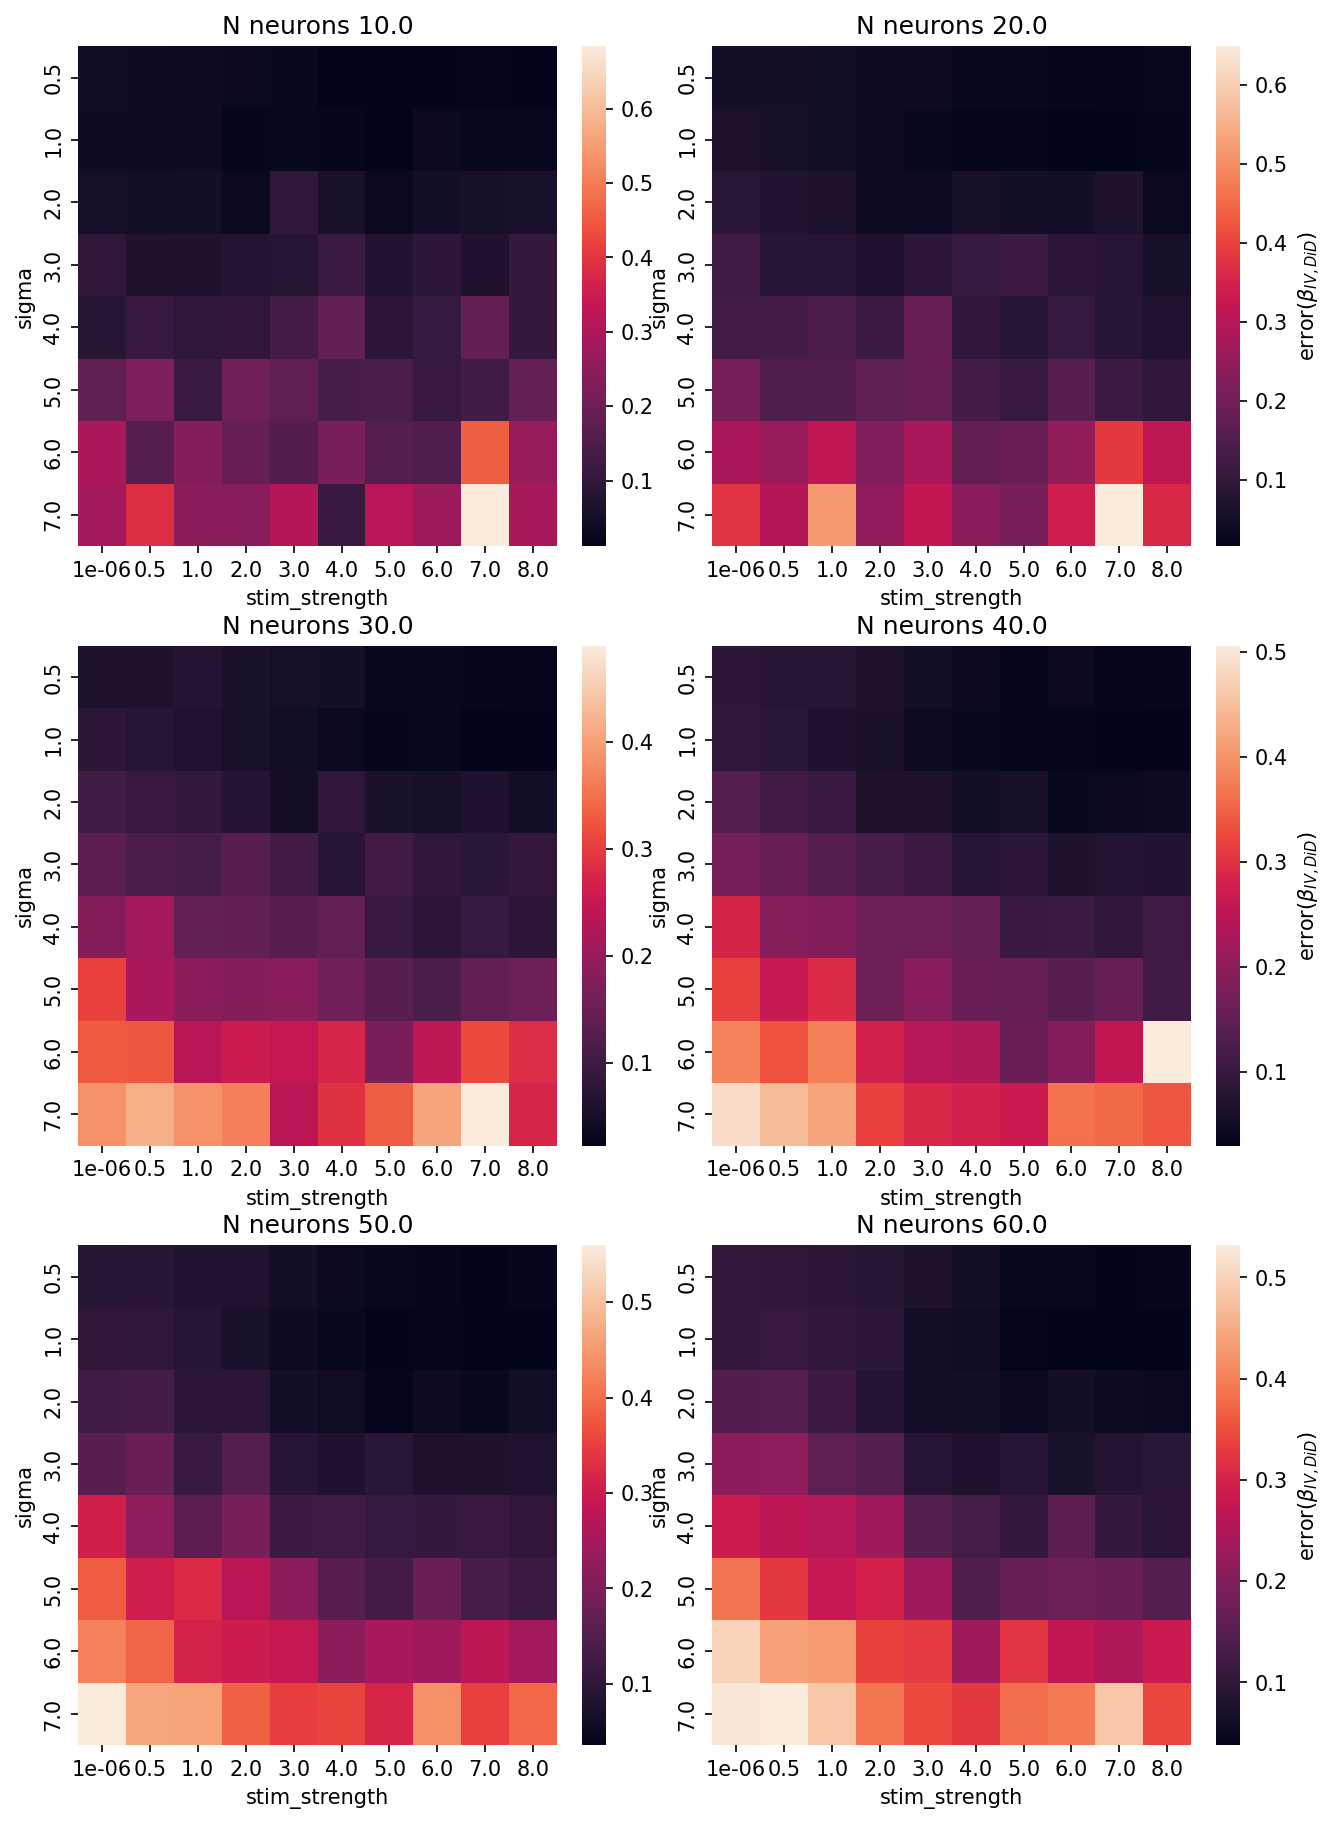

In [15]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10,15))
gs = gridspec.GridSpec(3, 2, figure=fig)
for i, (n_neurons, df) in enumerate(errors[k].groupby('n_neurons')):
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[i], width_ratios=[1,0.05], wspace=0.1)
    ax = fig.add_subplot(gs00[0,0])
    cax = fig.add_subplot(gs00[0,1])
    sns.heatmap(
        df.pivot('sigma', 'stim_strength', 'error_beta_iv_did'), 
#         annot=df.pivot('sigma', 'stim_strength', 'error_beta_iv_did'), 
        cbar_ax=cax, ax=ax, cbar_kws={'label': r'$\mathrm{error}(\beta_{IV,DiD})$' if i%2!=0 else ''})
    ax.set_title(f'N neurons {n_neurons}')

AttributeError: 'NoneType' object has no attribute 'dpi_scale_trans'

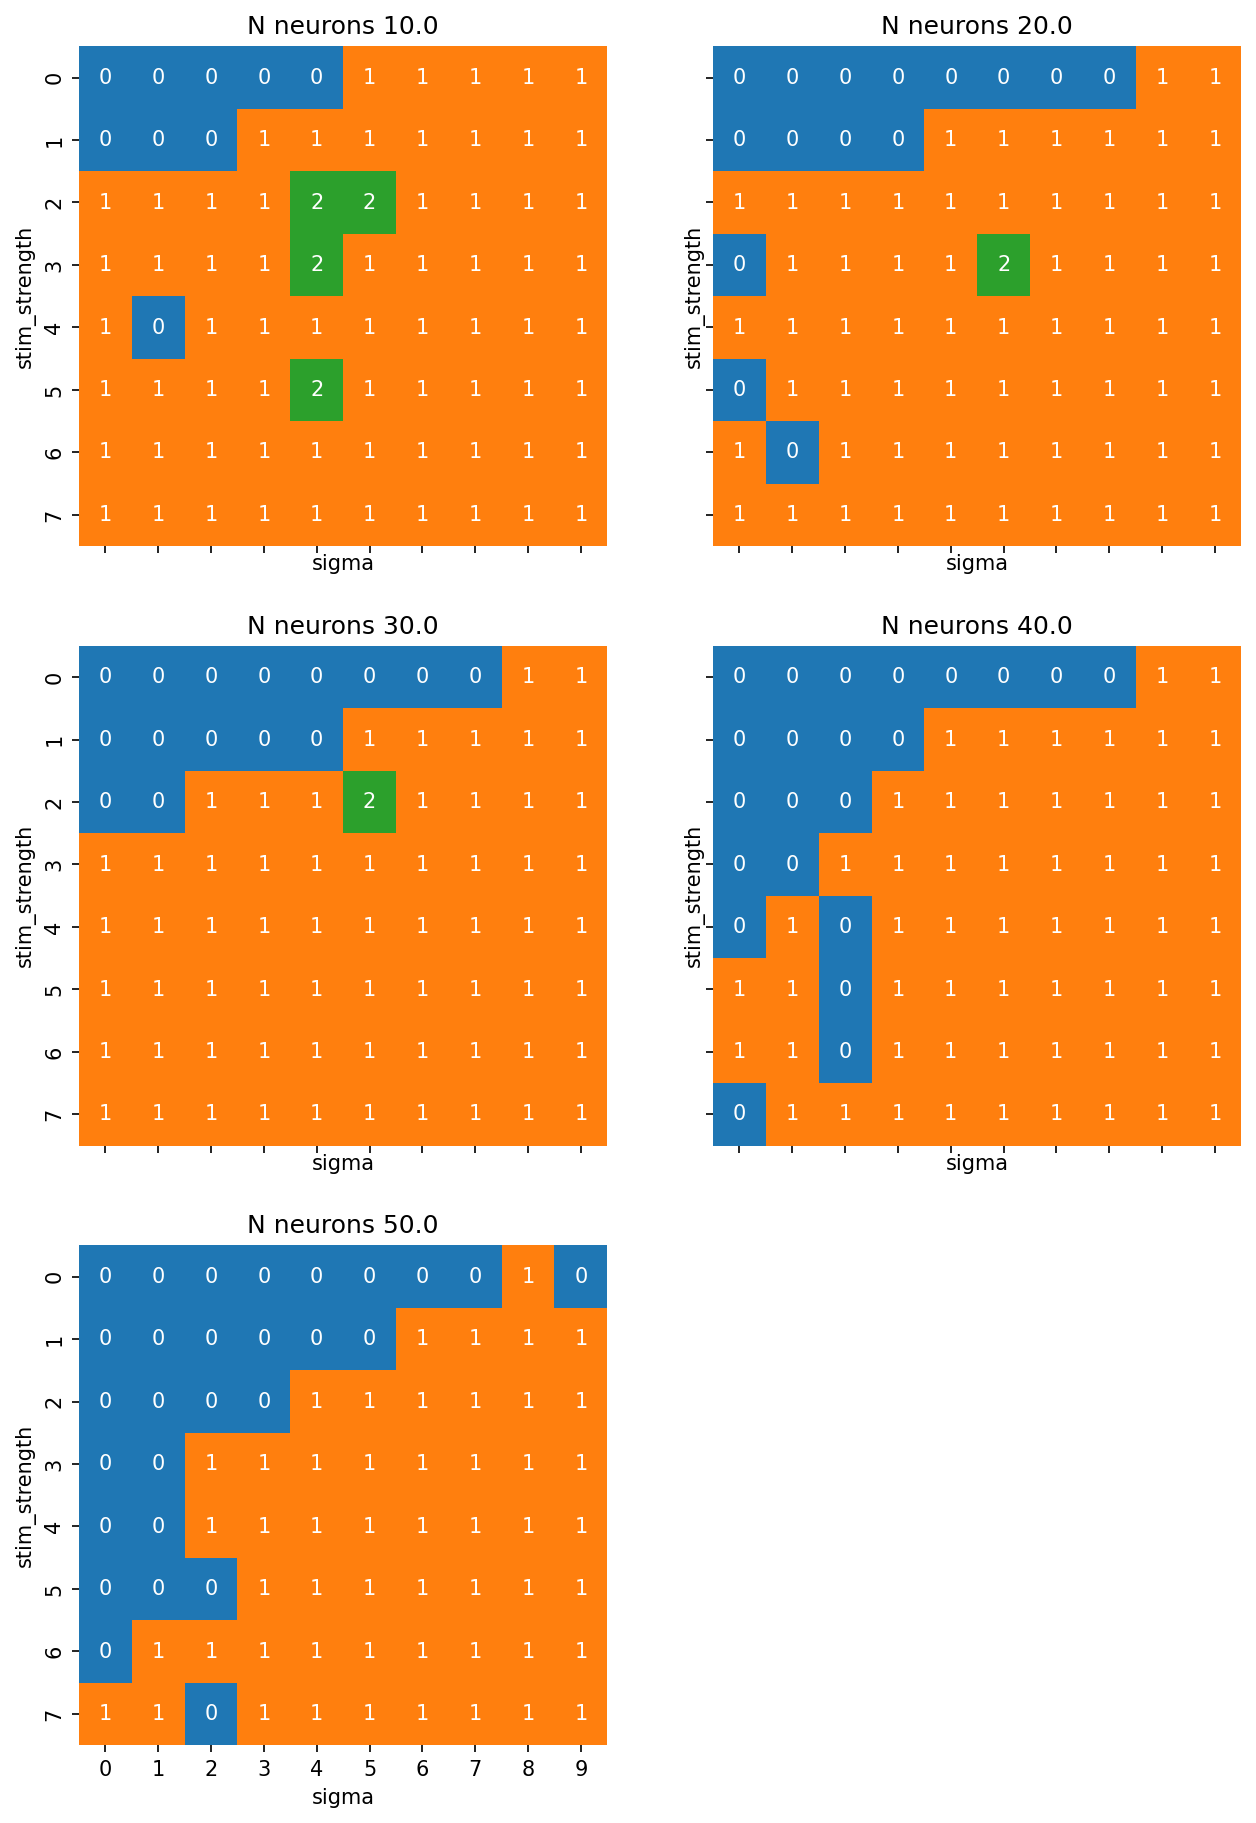

In [16]:
k = 'negatives'
import matplotlib.gridspec as gridspec
fig, axs = plt.subplots(3, 2, figsize=(10,15), sharex=True, sharey=True)
axs = axs.ravel()
axs[-1].remove()
for i, (n_neurons, df) in enumerate(errors[k].groupby('n_neurons')):
    ax = axs[i]
    argmin_err = np.concatenate(
    [df.pivot('sigma', 'stim_strength', 'error_beta_ols_did').values[:,:,None], 
     df.pivot('sigma', 'stim_strength', 'error_beta_iv_did').values[:,:,None], 
     df.pivot('sigma', 'stim_strength', 'error_beta_brew_did').values[:,:,None]], axis=2).argmin(2)
    sns.heatmap(
        argmin_err, 
        annot=argmin_err, 
        cmap=['C0', 'C1', 'C2'], vmin=0, vmax=2, ax=ax, cbar=False)
    ax.set_title(f'N neurons {n_neurons}')

    ax.set_xlabel('sigma')
    ax.set_ylabel('stim_strength')

In [ ]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10,15))
gs = gridspec.GridSpec(3, 2, figure=fig)
for i, (n_neurons, df) in enumerate(errors[k].groupby('n_neurons')):
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[i], width_ratios=[1,0.05], wspace=0.1)
    ax = fig.add_subplot(gs00[0,0])
    cax = fig.add_subplot(gs00[0,1])
    sns.heatmap(
        df.pivot('sigma', 'stim_strength', 'error_beta_ols_did') - df.pivot('sigma', 'stim_strength', 'error_beta_iv_did'), 
#         annot=df.pivot('sigma', 'stim_strength', 'error_diff_ols_iv_did'), 
        cmap='cubehelix', vmin=-5, vmax=5, cbar_ax=cax, ax=ax, 
        cbar_kws={'label': r'$\mathrm{error}(\beta_{DiD}) - \mathrm{error}(\beta_{IV,DiD})$' if i%2!=0 else ''})
    ax.set_title(f'N neurons {n_neurons}')

# Convergence

In [ ]:
samples = compute_all_samples(data_path)

In [ ]:
index = errors[k].query('n_neurons==50 and stim_strength==7 and sigma==6').iloc[0].name

In [ ]:
index

In [ ]:
errors[k].loc[index]

In [ ]:
plot_regression(samples, index, ['beta_ols_did','beta_iv_did','beta_brew_did'])

In [ ]:
plot_false_positives(samples, index, ['beta_ols_did', 'beta_iv_did', 'beta_brew_did'])

In [ ]:
error_convergence = compute_error_convergence(data_path)

In [ ]:
plot_error_convergence(error_convergence, index)